# Imports

In [2]:
%load_ext autoreload

In [34]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
import os 
import joblib
import time 
import seaborn as sns
from utils import *
import torch
import genbmm
import umap.umap_ as umap
import utils

from scipy.stats import poisson
from plotnine import ggplot, aes, geom_jitter, scale_x_discrete, labs, ggtitle, theme_minimal, theme, element_text
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Models
import hierarchical_clustering as hc
from hmmlearn import hmm
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, PoissonRegressor
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


# Own model 
from torch_hmm.models import HMM
from torch_hmm.training import train_hmm

In [4]:
fd = os.open("state_id.txt", os.O_RDONLY)
state_path = os.read(fd, 1024).decode('utf-8').splitlines()[0]
os.close(fd)

fd = os.open("head_id.txt", os.O_RDONLY)
head_path = os.read(fd, 1024).decode('utf-8').splitlines()[0]
os.close(fd)

fd = os.open("ensemble_id.txt", os.O_RDONLY)
ensemble_path = os.read(fd, 1024).decode('utf-8').splitlines()[0]
os.close(fd)


df_state = pd.read_csv(state_path)
df_head = pd.read_csv(head_path)
df_ensamble = pd.read_csv(ensemble_path)

In [5]:
X_head = df_head.drop(columns = "head_direction")
y_head = df_head["head_direction"]

X_state = df_state.drop(columns = "state")
y_state = df_state["state"]

X_ensamble = df_ensamble.drop(columns = ["head_direction", "state"])
y_ensamble = df_ensamble[["head_direction", "state"]]

# Visualization

In [31]:
df = pd.read_csv("df.csv")
X = df.drop(columns= ["headAngel", "sin_angel", "cos_angel"])
y = df.headAngel

df["time"] = range(1, X.shape[0]+1) 

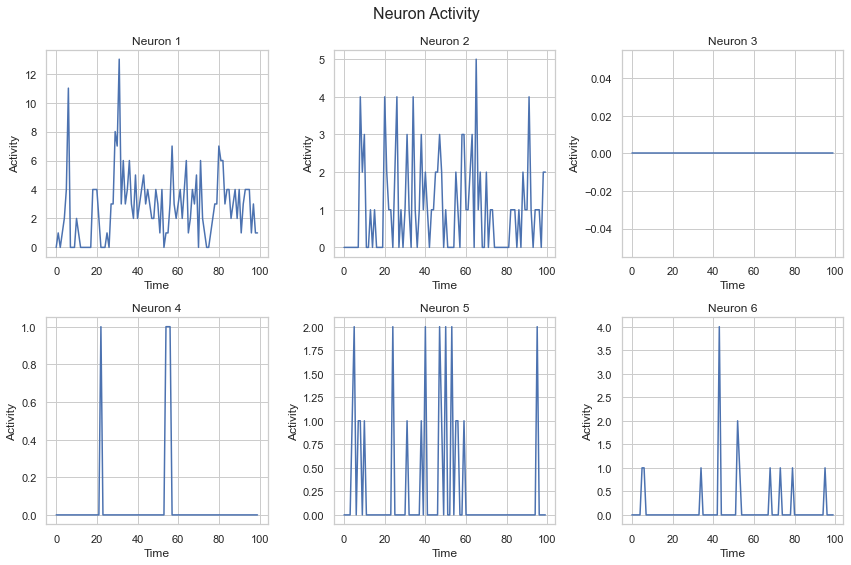

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Neuron Activity", fontsize=16)

t = 100 

for i in range(6):
    row, col = divmod(i,3)
    ax = axes[row, col]
    
    ax.plot(range(t), df[f"cell_{i}"][0:t])
    ax.set_title(f"Neuron {i + 1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Activity")

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

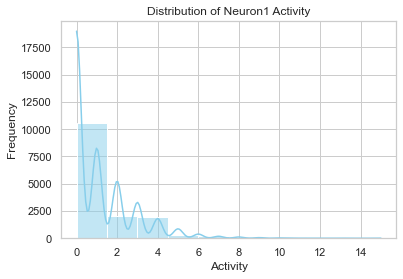

In [29]:
# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a histogram to show the distribution of Neuron1's activity
sns.histplot(df['cell_1'], bins=10, kde=True, color='skyblue')

# Set labels and title
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.title('Distribution of Neuron1 Activity')

# Show the plot
plt.show()

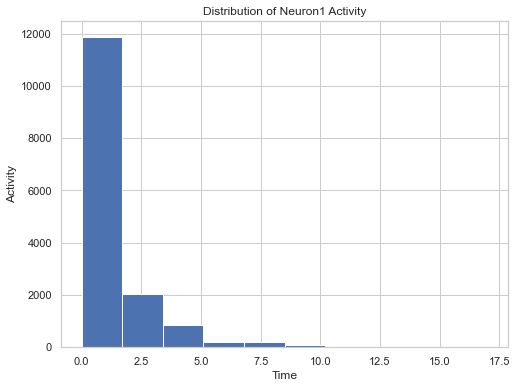

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot for the distribution of Neuron1's activity
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

plt.hist(df["cell_0"])

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Activity')
plt.title('Distribution of Neuron1 Activity')

# Show the plot
plt.show()


# XGBoost predictions

## Classifier

In [70]:
num_intervals = 24
interval_size = (2 * np.pi) / num_intervals

def map_to_discrete_state(x):
    interval_idx = int(x / interval_size)
    return interval_idx

y_head_state = [map_to_discrete_state(x) for x in y_head]

In [71]:
model_head_class =  xgb.XGBClassifier(
    n_estimators=100,            # number of trees (boosting rounds)
    max_depth=3,                 # maximum depth of each tree
    learning_rate=0.1,           # step size shrinkage to prevent overfitting
    random_state=42              # seed for reproducibility
)

model_head_class.fit(X_ensamble, y_head_state)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

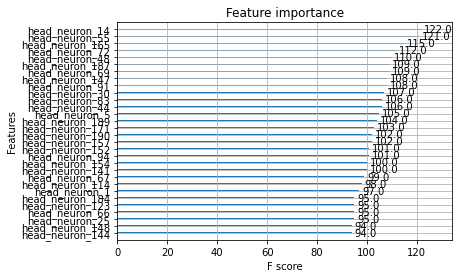

In [72]:
xgb.plot_importance(model_head_class, max_num_features=30)
plt.show()

In [68]:
model_state_class =  xgb.XGBClassifier(
    n_estimators=100,            # number of trees (boosting rounds)
    max_depth=3,                 # maximum depth of each tree
    learning_rate=0.1,           # step size shrinkage to prevent overfitting
    random_state=42              # seed for reproducibility
)

model_state_class.fit(X_ensamble, y_state-1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

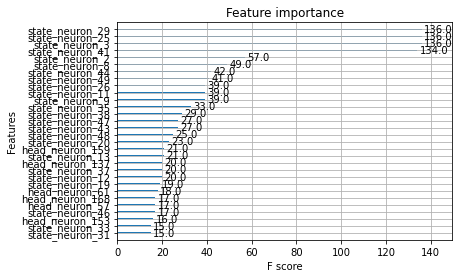

In [69]:
xgb.plot_importance(model_state_class, max_num_features=30)
plt.show()

## Neuron prediction

In [74]:
head_neuron = X_ensamble["head_neuron_0"]
X_ensamble_sub = X_ensamble.drop(columns="head_neuron_0")

In [75]:
model = xgb.XGBRegressor(
    objective='reg:tweedie',  # for regression
    n_estimators=100,            # number of trees (boosting rounds)
    max_depth=3,                 # maximum depth of each tree
    learning_rate=0.1,           # step size shrinkage to prevent overfitting
    random_state=42              # seed for reproducibility
)

model.fit(X_ensamble_sub, head_neuron)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:tweedie', predictor=None, ...)

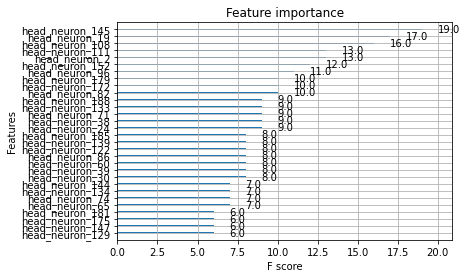

In [76]:
xgb.plot_importance(model, max_num_features=30)
plt.show()

Head neurons are only correlated with other head neurons, as expected. Neurons which are active at a head direction near the neuron we attempt to predict should be more correlated. 

In [83]:
state_neuron = X_ensamble["state_neuron_2"]
X_ensamble_sub = X_ensamble.drop(columns="state_neuron_2")

In [84]:
model = xgb.XGBRegressor(
    objective='reg:tweedie',  # for regression
    n_estimators=100,            # number of trees (boosting rounds)
    max_depth=3,                 # maximum depth of each tree
    learning_rate=0.1,           # step size shrinkage to prevent overfitting
    random_state=42              # seed for reproducibility
)

model.fit(X_ensamble_sub, state_neuron)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:tweedie', predictor=None, ...)

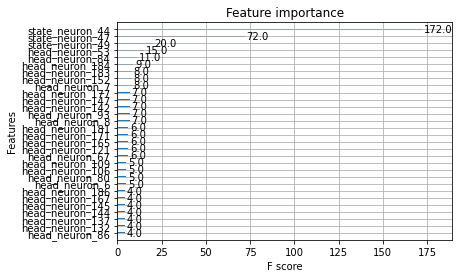

In [85]:
xgb.plot_importance(model, max_num_features=30)
plt.show()

Only need to use one state neuron to describe another, since if they are active in the same state they are near perfectly correlated.

# GLM

## Logistic Regression

In [86]:
def convert_to_binary(value):
    return 1 if value != 0 else 0


X_is_active = X_ensamble.applymap(convert_to_binary)

In [89]:
head_neuron_binary = X_is_active["head_neuron_0"]
X_is_active_sub = X_is_active.drop(columns = "head_neuron_0")


In [92]:
model_logreg = LogisticRegression()

model_logreg.fit(X_is_active_sub, head_neuron_binary)

C:\Users\eiier\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

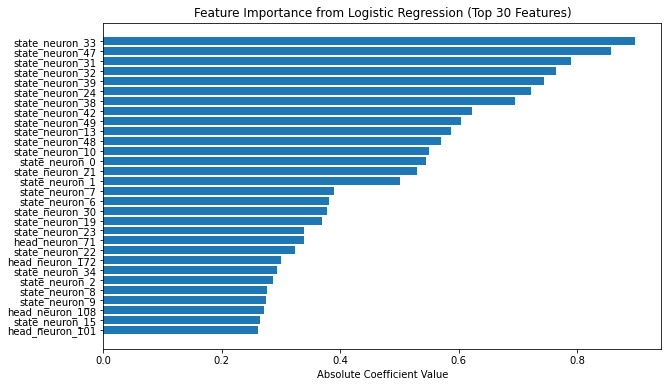

In [96]:
# Get feature coefficients (importance) from the model
coefficients = model.coef_[0]

feature_names = X_is_active_sub.columns

# Create a DataFrame to store coefficients and feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients by absolute value for better visualization
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Select the top 30 features for plotting
top_30_features = coef_df.iloc[:30]

# Plot the feature importance for the top 30 features
plt.figure(figsize=(10, 6))
plt.barh(top_30_features['Feature'], top_30_features['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance from Logistic Regression (Top 30 Features)')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


## Poisson

In [100]:
head_neuron = X_ensamble["head_neuron_0"]
X_ensamble_sub = X_ensamble.drop(columns="head_neuron_0")

In [101]:
model = PoissonRegressor(alpha=1.0001, max_iter=100)

model.fit(X_ensamble_sub, head_neuron)

PoissonRegressor(alpha=1.0001)

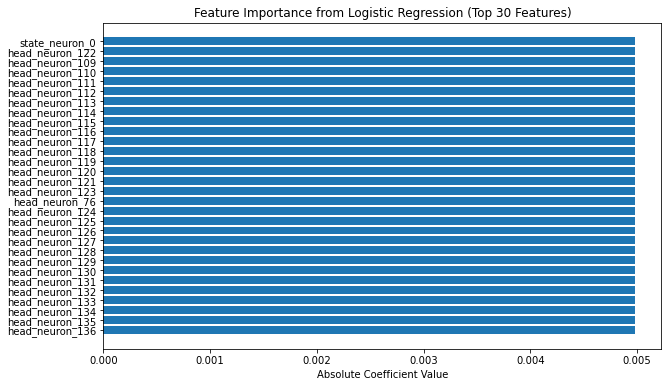

In [102]:
# Get feature coefficients (importance) from the model
coefficients = model.coef_[0]

feature_names = X_is_active_sub.columns

# Create a DataFrame to store coefficients and feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients by absolute value for better visualization
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Select the top 30 features for plotting
top_30_features = coef_df.iloc[:30]

# Plot the feature importance for the top 30 features
plt.figure(figsize=(10, 6))
plt.barh(top_30_features['Feature'], top_30_features['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance from Logistic Regression (Top 30 Features)')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

# Distance clustering

In [6]:
df_real_data = pd.read_csv("df.csv")

In [7]:
X_real_data = df_real_data.drop(columns = ["headAngel", "sin_angel", "cos_angel"])

# Calculate the sum of activity for each column
column_sums = X_real_data.sum()

# Identify columns where the sum of activity is below 100
columns_to_drop = column_sums[column_sums < 100].index

# Drop the identified columns from the DataFrame
X_filtered = X_real_data.drop(columns=columns_to_drop)

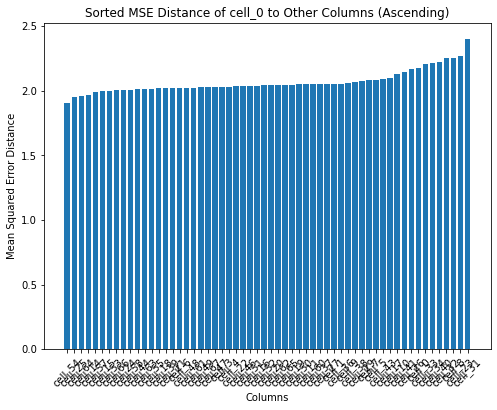

In [83]:
# Create a sample DataFrame (replace with your own data)
df = X_filtered

# Choose the target column for distance measurement
target_column = 'cell_0'

# Create a StandardScaler to normalize the DataFrame
scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Calculate the mean squared error (MSE) distances from the target column
mse_distances = []
for column in df_normalized.columns:
    if column != target_column:
        mse = mean_squared_error(df_normalized[target_column], df_normalized[column])
        mse_distances.append(mse)

# Sort the distances in ascending order and get the corresponding column names
sorted_mse_distances, sorted_columns = zip(*sorted(zip(mse_distances, df_normalized.columns)))

# Plot the sorted mean MSE distances
plt.figure(figsize=(8, 6))
plt.bar(sorted_columns, sorted_mse_distances)
plt.xlabel('Columns')
plt.ylabel('Mean Squared Error Distance')
plt.title(f'Sorted MSE Distance of {target_column} to Other Columns (Ascending)')
plt.xticks(rotation=45)
plt.show()


c:\Users\eiier\Documents\Subjects\Master\HMM_model\utils.py:193: UserWarning: FixedFormatter should only be used together with FixedLocator


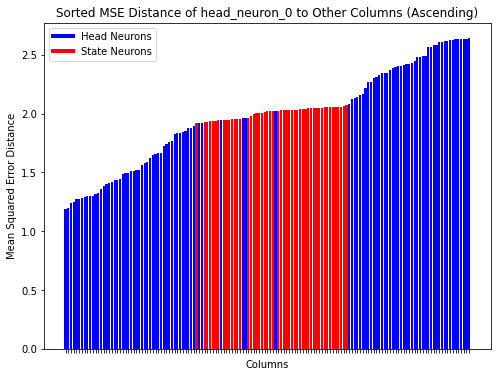

In [17]:
plot_mse_distances("head_neuron_0", X_ensamble)

See that absolute distance is not a measure of correlation, but distance from mean is.  

c:\Users\eiier\Documents\Subjects\Master\HMM_model\utils.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator


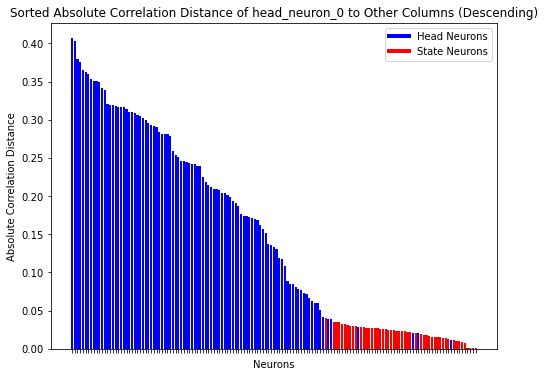

In [8]:
target_column = "head_neuron_0"
correlation_distances = compute_absolute_correlation(X_ensamble, target_column)
plot_correlation_distances(correlation_distances, target_column)

c:\Users\eiier\Documents\Subjects\Master\HMM_model\utils.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator


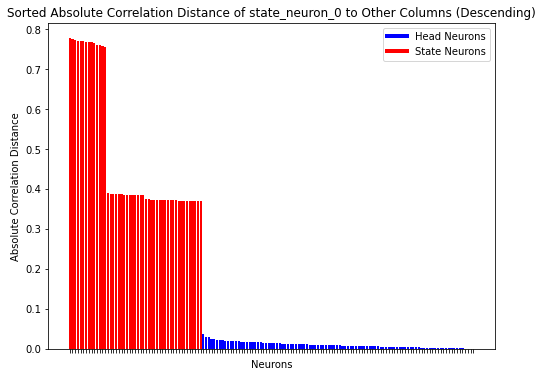

In [9]:
target_column = 'state_neuron_0'
correlation_distances = compute_absolute_correlation(X_ensamble, target_column)
plot_correlation_distances(correlation_distances, target_column)

c:\Users\eiier\Documents\Subjects\Master\HMM_model\utils.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator


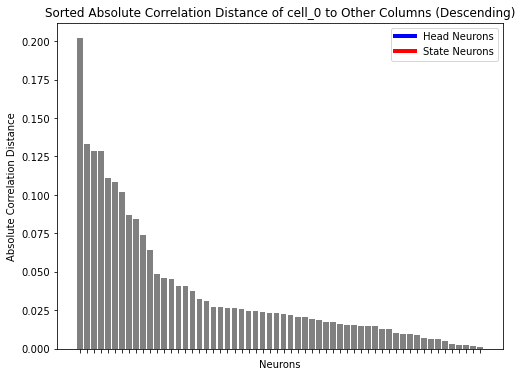

In [10]:
target_column = "cell_0"
correlation_distances = compute_absolute_correlation(X_filtered, target_column)
plot_correlation_distances(correlation_distances, target_column)

# Hierarchy Clustering

## Correlation

In [56]:
X_head, y_head= simulate_head(20, 0.005, 2, 5, 2000)
X_state, y_state = simulate_state(20, 3, (5,4,3), 2000)

X_ensamble = pd.concat([X_head, X_state], axis = 1)

In [57]:
data = X_ensamble

# plt.figure(figsize=(15,10))
correlations = data.corr()
dissimilarity = 1 - abs(correlations)
# sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
#             annot_kws={"size": 7}, vmin=-1, vmax=1);

### Hierarchical Clustering

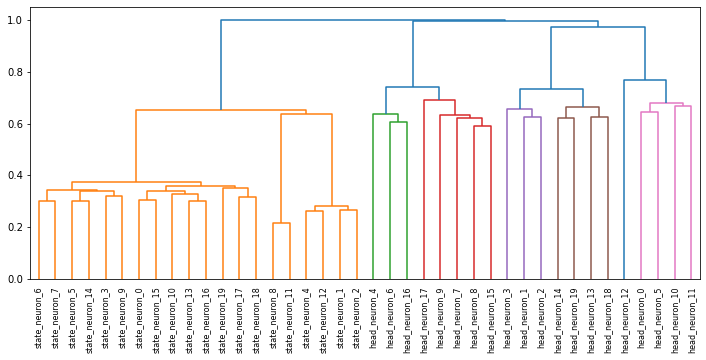

In [58]:
plt.figure(figsize=(12,5))
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=data.columns, orientation='top', 
           leaf_rotation=90);

In [62]:
y_state[20:40]

array([1, 1, 2, 2, 2, 1, 2, 2, 3, 2, 2, 1, 2, 3, 3, 1, 2, 3, 1, 1])

### K-means

In [60]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(dissimilarity)
kmeans.labels_

C:\Users\eiier\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Single

In [11]:
linkage_matrix = linkage(X_ensamble.T, method = "complete")

In [12]:
linkage_matrix.shape

(149, 4)

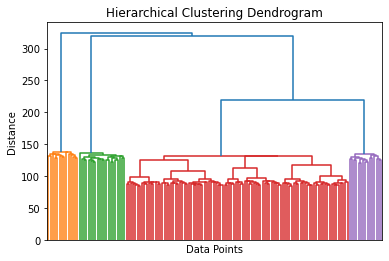

In [15]:
dendrogram(linkage_matrix, color_threshold= 200, no_labels=True)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [97]:
data = X_ensamble.T

hierarchical_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
labels = hierarchical_cluster.fit_predict(data)

C:\Users\eiier\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


In [100]:
X_ensamble.iloc[:, labels == 3]

,head_neuron_0,head_neuron_1,head_neuron_2,head_neuron_3,head_neuron_4,head_neuron_5,head_neuron_6,head_neuron_7,head_neuron_8,head_neuron_9,...,head_neuron_190,head_neuron_191,head_neuron_192,head_neuron_193,head_neuron_194,head_neuron_195,head_neuron_196,head_neuron_197,head_neuron_198,head_neuron_199
0,4,1,0,1,0,1,1,0,3,0,...,3,0,0,0,1,1,0,0,2,0
1,0,0,2,0,1,0,1,3,1,0,...,0,1,0,2,0,3,1,0,1,0
2,1,0,1,1,2,0,2,0,0,0,...,0,0,4,1,0,4,2,0,0,0
3,1,1,0,0,0,0,3,0,1,1,...,1,0,0,0,0,1,1,0,0,1
4,1,0,0,2,0,2,1,0,1,0,...,1,0,0,1,5,1,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,1,3,0,2,0,3,5,1,0,...,0,0,2,1,0,1,2,1,0,0
4996,1,0,1,0,0,2,0,1,0,1,...,0,0,1,3,2,0,0,1,0,1
4997,1,2,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,3
4998,0,0,1,0,1,0,0,2,1,0,...,0,0,2,3,0,0,2,1,0,0


In [55]:
linkage_matrix_head = linkage(X_head.T, method = "ward")

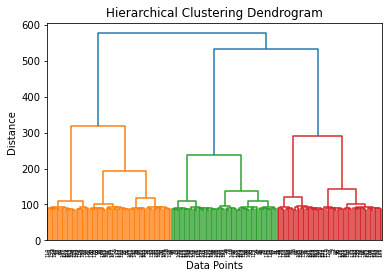

In [56]:
dendrogram(linkage_matrix_head, )
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [36]:
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# Example data (replace with your own data)
data = X_ensamble.T

# Perform hierarchical clustering
linkage_matrix = linkage(data, method='ward')

# Choose a threshold height to cut the dendrogram (adjust as needed)
threshold = 200

# Assign data points to clusters based on the threshold
clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')

# Determine the number of clusters
num_clusters = len(np.unique(clusters))

# Create a dictionary to store data points for each cluster
cluster_indices = {i: [] for i in range(1, num_clusters + 1)}

# Assign data points to their respective clusters
for i, cluster_id in enumerate(clusters):
    cluster_indices[cluster_id].append(i)

# Print the number of clusters and the indices of data points in each cluster
print(f'Number of Clusters: {num_clusters}')
for cluster_id, data_indices in cluster_indices.items():
    print(f'Cluster {cluster_id} - Data Points: {data_indices}')


Number of Clusters: 8
Cluster 1 - Data Points: [8, 10, 16, 17, 20, 21, 22, 23, 27, 32, 33, 34, 35, 39, 40, 41, 43, 45, 46, 48, 49]
Cluster 2 - Data Points: [0, 2, 4, 5, 7, 12, 13, 14, 26, 28, 31, 36, 37, 42, 44]
Cluster 3 - Data Points: [1, 3, 6, 9, 11, 15, 18, 19, 24, 25, 29, 30, 38, 47]
Cluster 4 - Data Points: [53, 67, 76, 80, 98, 107, 109, 113, 117, 133, 147, 153, 154, 164, 169, 170, 177, 178, 200, 205, 212, 237, 239, 240, 249]
Cluster 5 - Data Points: [55, 58, 60, 64, 65, 66, 77, 79, 84, 92, 100, 102, 103, 115, 119, 123, 127, 130, 131, 134, 137, 139, 140, 141, 143, 144, 149, 155, 157, 172, 182, 183, 187, 191, 199, 201, 206, 209, 211, 214, 216, 217, 218, 222, 223, 227, 232, 244, 247]
Cluster 6 - Data Points: [50, 51, 59, 62, 63, 68, 71, 75, 81, 82, 83, 85, 86, 91, 94, 95, 96, 97, 99, 104, 106, 108, 112, 116, 120, 122, 125, 126, 128, 129, 135, 138, 145, 148, 150, 151, 152, 156, 162, 165, 166, 167, 173, 175, 176, 180, 181, 185, 186, 190, 192, 194, 196, 198, 208, 210, 213, 220, 221, 2

# UMAP

In [77]:
data_state, state_sim = simulate_state(num_neuron=50, num_states=3, frequency=5, data_length=5000)

data_head, hd_sim = simulate_head(num_neuron = 100,
                        back_firing = 0.005,        
                        peak_firing = 2,
                        tuning_width = 5,
                        data_length=5000)

In [78]:
data_ensamble = pd.concat([data_state, data_head], axis = 1)

In [79]:
X_scaled = StandardScaler().fit_transform(data_ensamble)

In [52]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(X_scaled)

In [53]:
import numpy as np

def map_list_to_segments(values, num_segments=10):
    segment_indices = []

    for value in values:
        if value < 0:
            value = 0
        elif value >= 2 * np.pi:
            value = 2 * np.pi - 1e-6  # To ensure that 2π gets mapped to the last segment.
        
        segment_width = (2 * np.pi) / num_segments
        segment_index = int(value / segment_width)
        segment_indices.append(segment_index)

    return segment_indices

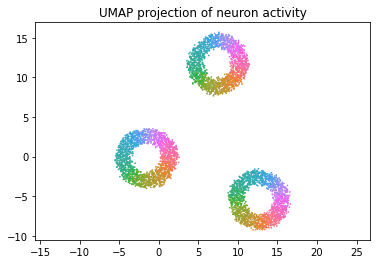

In [84]:
X_scaled = StandardScaler().fit_transform(data_ensamble)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

segment_hd = map_list_to_segments(hd_sim, len(hd_sim))
custom_palette = sns.color_palette("husl", len(segment_hd))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in segment_hd], s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

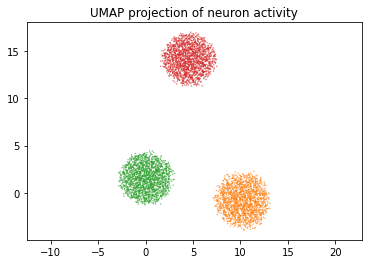

In [91]:
X_scaled = StandardScaler().fit_transform(data_state)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[sns.color_palette()[x] for x in state_sim], s = 0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

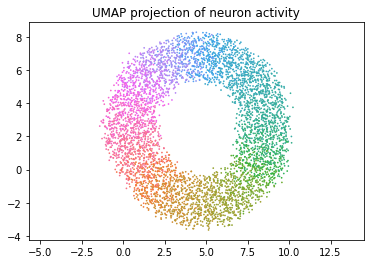

In [86]:
X_scaled = StandardScaler().fit_transform(data_head)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

segment_hd = map_list_to_segments(hd_sim, len(hd_sim))
custom_palette = sns.color_palette("husl", len(segment_hd))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in segment_hd], s = 0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

In [87]:
data_state1, state_sim1  = simulate_state(num_neuron=50, num_states=3, frequency=5, data_length=5000)
data_state2, state_sim2  = simulate_state(num_neuron=50, num_states=4, frequency=1, data_length=5000)

In [88]:
import itertools

# Replace these with your actual vectors
vector1 = state_sim1
vector2 = state_sim2

# Create a dictionary to map unique combinations to numbers
combo_to_number = {}

# Create a counter to assign unique numbers
counter = 0

combination = []

# Use itertools.product to generate unique combinations
for i in range(len(vector1)):
    combo = (vector1[i], vector2[i])
    combination.append(combo)
    if combo not in combo_to_number:
        combo_to_number[combo] = counter
        counter += 1


In [89]:
combination = list(combination)
ensemble_state = [combo_to_number[combo] for combo in combination]

In [90]:
data_state_ensamble = pd.concat([data_state1, data_state2], axis = 1)

X_scaled = StandardScaler().fit_transform(data_state_ensamble)

reducer = umap.UMAP(n_neighbors=20, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

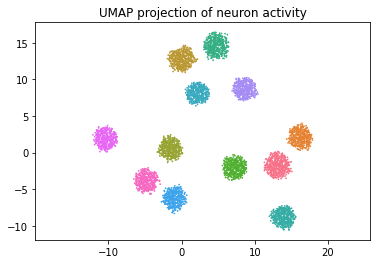

In [92]:
data_state_ensamble = pd.concat([data_state1, data_state2], axis = 1)

X_scaled = StandardScaler().fit_transform(data_state_ensamble)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

custom_palette = sns.color_palette("husl", len(set(ensemble_state)))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in ensemble_state], s = 0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

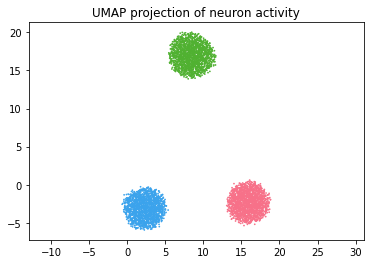

In [93]:
X_scaled = StandardScaler().fit_transform(data_state1)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

state_sim1_reduced = np.array(state_sim1) - 1

custom_palette = sns.color_palette("husl", len(set(state_sim1_reduced)))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in state_sim1_reduced], s = 0.5 )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

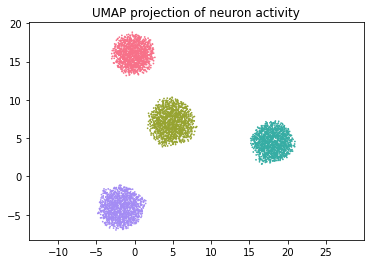

In [94]:
X_scaled = StandardScaler().fit_transform(data_state2)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

state_sim2_reduced = np.array(state_sim2) - 1

custom_palette = sns.color_palette("husl", len(set(state_sim2_reduced)))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in state_sim2_reduced], s = 0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

### Real Data

In [95]:
df = pd.read_csv("df.csv")

In [97]:
X = df.drop(columns= ["headAngel", "sin_angel", "cos_angel"])
y = df.headAngel

In [98]:
X_scaled = StandardScaler().fit_transform(X)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

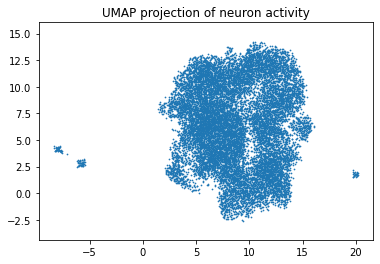

In [100]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],  s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

In [102]:
df_pure = df[~np.isnan(df["headAngel"])]

In [106]:
X_pure = df_pure.drop(columns= ["headAngel", "sin_angel", "cos_angel"])
y_pure = df_pure.headAngel

In [107]:
X_scaled = StandardScaler().fit_transform(X_pure)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

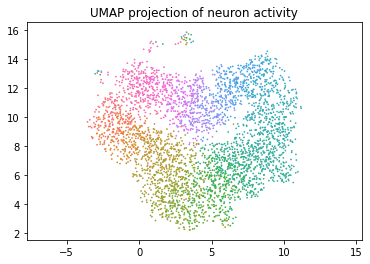

In [108]:
segment_hd = map_list_to_segments(y_pure, len(y_pure))
custom_palette = sns.color_palette("husl", len(segment_hd))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=x, s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

# Head model

## Torch model

### With gradient search

In [5]:
n_states = 12
X = torch.tensor(X_ensamble.values)
M = X.shape[1]
data_path = ensemble_path
learning_rate = 0.1
max_itterations = 1000
tolerance = 1
n_retraining = 1

path = get_sim_id(data_path) + f"_ms{n_states}"

model_list = list()
score_list = list()
start_time = time.time()

for _ in range(n_retraining):
    model = HMM(N = n_states, m_dimensions=M)
    train_hmm(model, X, max_iterations=max_itterations,
                  tolerance=tolerance, learning_rate=learning_rate)
    
    model_list.append(model)
    score_list.append(model.forward(X))
    print(f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

Iteration 1: Log Likelihood = -1623461.5000
Iteration 2: Log Likelihood = -1543319.6250
Iteration 3: Log Likelihood = -1480429.3750
Iteration 4: Log Likelihood = -1424826.5000
Iteration 5: Log Likelihood = -1372934.0000
Iteration 6: Log Likelihood = -1322317.8750
Iteration 7: Log Likelihood = -1277627.5000
Iteration 8: Log Likelihood = -1235080.5000
Iteration 9: Log Likelihood = -1193630.3750
Iteration 10: Log Likelihood = -1155048.7500
Iteration 11: Log Likelihood = -1120491.3750
Iteration 12: Log Likelihood = -1090232.3750
Iteration 13: Log Likelihood = -1063938.2500
Iteration 14: Log Likelihood = -1040470.7500
Iteration 15: Log Likelihood = -1019689.7500
Iteration 16: Log Likelihood = -1001272.9375
Iteration 17: Log Likelihood = -984748.0000
Iteration 18: Log Likelihood = -969657.6875
Iteration 19: Log Likelihood = -956175.0625
Iteration 20: Log Likelihood = -944504.6875
Iteration 21: Log Likelihood = -934340.0000
Iteration 22: Log Likelihood = -925072.1875
Iteration 23: Log Likelih

KeyboardInterrupt: 

### With baum-welch

In [5]:
%autoreload
from torch_hmm.model_bayes import HMM_bayes

In [50]:
import torch
import torch.distributions as dist
import genbmm


class HMM_bayes(torch.nn.Module):
    """
    Hidden Markov Model with discrete observations.
    """
    def __init__(self, n_states, m_dimensions, max_itterations = 100, tolerance = 0.1, verbose = True):
        super(HMM_bayes, self).__init__()
        self.n_states = n_states  # number of states
        self.T_max = None # Max time step
        self.m_dimensions = m_dimensions
        
        self.max_itterations = max_itterations
        self.tolerance = tolerance
        
        self.verbose = verbose
        
        # A_mat
        self.transition_matrix = torch.nn.functional.softmax(torch.randn(self.n_states, self.n_states), dim = 0)
        self.log_transition_matrix = self.transition_matrix.log()
        
        # b(x)
        self.lambdas = torch.exp(torch.randn(self.n_states, m_dimensions))
        self.log_emission_matrix = None
        self.emission_matrix = None

        # pi
        self.unnormalized_state_priors = torch.nn.Parameter(torch.randn(self.n_states))
        self.log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
        self.state_priors = torch.exp(self.log_state_priors)
        

        # use the GPU
        self.is_cuda = torch.cuda.is_available()
        if self.is_cuda:
            self.cuda()

    def emission_model(self, x, log = True):
        """
        x: LongTensor of shape (T_max, m_dimensions)

        Get observation log probabilities
        """
        # Compute Poisson log probabilities for each lambda in parallel
        poisson_dist = dist.Poisson(self.lambdas)
        log_probabilities = torch.zeros(x.shape[0], self.n_states)
        for t in range(x.shape[0]):
            log_probabilities[t,:] = poisson_dist.log_prob(x[t,:]).sum(dim=1)
        if log:
            return log_probabilities
        
        return log_probabilities.exp()
        
    
    def alpha_calc(self):
        alpha = torch.zeros(self.T_max, self.n_states).float()
        if self.is_cuda:
            alpha = alpha.cuda()
        
        alpha[0,:] = self.emission_matrix[0,:] + self.log_state_priors
        
        for t in range(1, self.T_max):
            alpha[t, :] = self.emission_matrix[t, :] * torch.matmul(self.transition_matrix, alpha[t-1, :])
        
        return alpha
    
    def beta_calc(self):
        beta = torch.ones(self.T_max, self.n_states).float()
        if self.is_cuda:
            beta = beta.cuda()
        
        for t in range(self.T_max - 2, -1, -1):
            beta_t_s = torch.zeros(self.n_states).float()
            for s in range(self.n_states):
                for k in range(self.n_states):
                    beta_t_s[s] += beta[t+1,k]*self.transition_matrix[s,k]*self.emission_matrix[t+1,k]
            beta[t,:] = beta_t_s
        
        return beta
                    
    def log_alpha_calc(self):
        """
        self.log_emission_matrix: longTensor of shape (T_max, n_states)

        Returns:
            log_alpha: floatTensor of shape (T_max, n_states)
        """
        assert self.log_emission_matrix is not None, "No emission matrix"
        assert self.T_max is not None, "No maximum time"
        
        log_alpha = torch.zeros(self.T_max, self.n_states).float()
        if self.is_cuda:
            log_alpha = log_alpha.cuda()

        log_alpha[0, :] = self.log_emission_matrix[0, :] + self.log_state_priors
        
        
        # log_alpha[1:self.T_max,:] = self.log_emission_matrix[1:self.T_max,:] + self.log_transition_matrix[0:(self.T_max-1), :]

        for t in range(1, self.T_max):
            log_alpha[t, :] = self.log_emission_matrix[t, :] + log_domain_matmul(self.log_transition_matrix, log_alpha[t-1, :])
        
        return log_alpha
    
    def log_beta_calc(self):
        assert self.log_emission_matrix is not None, "No emission matrix"
        
        log_beta = torch.zeros(self.T_max, self.n_states).float()
        if self.is_cuda:
            log_beta = log_beta.cuda()
        
        
        for t in range(self.T_max - 2, -1, -1):
            beta_t_s = torch.zeros(self.n_states).float()
            for s in range(self.n_states):
                log_probs = log_beta[t + 1,] + self.log_transition_matrix[:, s] + self.log_emission_matrix[t + 1, s]
                beta_t_s = torch.logsumexp(torch.stack([beta_t_s, log_probs], dim=0), dim=0)
            log_beta[t,:] = beta_t_s
        
        return log_beta
        
    
    def forward(self, x):
        """
        x: IntTensor of shape (T_max, m_dimensions)

        Compute log p(x)
        """
        self.T_max = x.shape[0]
        self.log_emission_matrix = self.emission_model(x)
        log_alpha = self.log_alpha_calc()

        log_prob = log_alpha[self.T_max-1, :].logsumexp(dim=0)
        return log_prob
    
    def get_lambdas(self):
        return self.lambdas
            
    
    def fit(self, x):
        """ Estimates optimal transition matrix and lambdas given the data x.

        Args:
            x (torch): T_max x m_dimensions
            log_alpha (torch) : T_max x N
            log_beta (torch) : T_max x N
        """
        
        self.T_max = x.shape[0]
        prev_log_likelihood = float('-inf')
        log_x = torch.log(x + 1e-16)
        
        for iteration in range(self.max_itterations):
            # Get emission matrix
            self.log_emission_matrix = self.emission_model(x)
            
            # E step
            ## Calculate log_alpha
            global log_alpha
            log_alpha = self.log_alpha_calc()
            
            ## Caculcate log_beta
            global log_beta
            log_beta = self.log_beta_calc()
            
            # Chack for tolerance
            log_likelihood = log_alpha[self.T_max - 1, :].logsumexp(dim = 0)
            log_likelihood_change = log_likelihood - prev_log_likelihood
            prev_log_likelihood = log_likelihood
            if self.verbose:
                if log_likelihood_change > 0:
                    print(f"{iteration + 1} {log_likelihood:.4f}  +{log_likelihood_change}")
                else:
                    print(f"{iteration + 1} {log_likelihood:.4f}  {log_likelihood_change}")
            
            if log_likelihood_change < self.tolerance and log_likelihood_change > 0:
                if self.verbose:
                    print("Converged (change in log likelihood within tolerance)")
                break
            
            ## Calculate log_gamma
            gamma_numerator = log_alpha + log_beta
            gamma_denominator = gamma_numerator.logsumexp(dim=1, keepdim=True)
            
            
            log_gamma = gamma_numerator - gamma_denominator.expand_as(gamma_numerator)
            
            ## Calculate log_xi
            xi_numerator = (log_alpha[:-1, :, None] + self.log_transition_matrix[None, :, :] + log_beta[1:, None, :] + self.log_emission_matrix[1:, None, :])
            xi_denominator = xi_numerator.logsumexp(dim = (1,2), keepdim=True)
            
            log_xi = xi_numerator - xi_denominator
            
            # M step
            ## Update pi
            self.log_state_priors = log_gamma[0,] - log_gamma.logsumexp(dim = 0)
            
            ## Updaten transition matrix
            trans_numerator = log_xi.logsumexp(dim = 0)
            trans_denominator = log_gamma[0:(self.T_max-1),:].logsumexp(dim = 0)           

            self.log_transition_matrix = trans_numerator - trans_denominator.view(-1, 1)
            
            ## Update lambda
            # log_numerator = genbmm.logbmm(log_gamma.t().unsqueeze(0).contiguous(), log_x.unsqueeze(1).contiguous())[0]
            # log_numerator = log_matrix_multiply(log_alpha.t(), log_x)
            lambda_numerator = log_domain_matmul(log_gamma.t(), log_x, dim_1=False)
            lambda_denominator = log_gamma.logsumexp(dim = 0)
            
            self.lambdas = torch.exp(lambda_numerator - lambda_denominator.view(-1,1))
            
            
            if self.verbose and iteration == self.max_itterations -1:
                print("Max itteration reached.")
                
    
    def predict(self, x):
        """
        x: IntTensor of shape (T_max, m_dimensions)

        Find argmax_z log p(z|x)
        """
        if self.is_cuda:
            x = x.cuda()

        T_max = x.shape[0]
        log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
        log_delta = torch.zeros(T_max, self.n_states).float()
        psi = torch.zeros(T_max, self.n_states).long()
        if self.is_cuda:
            log_delta = log_delta.cuda()
            psi = psi.cuda()

        self.log_emission_matrix = self.emission_model(x)
        
        log_delta[0, :] = self.log_emission_matrix[0,:] + log_state_priors
        for t in range(1, T_max):
            max_val, argmax_val = log_domain_matmul(self.log_transition_matrix, log_delta[t-1,:], max = True)
            log_delta[t, :] = self.log_emission_matrix[t,:] + max_val
            psi[t, :] = argmax_val

        # This next part is a bit tricky to parallelize across the batch,
        # so we will do it separately for each example.
        z_star = torch.zeros(T_max).long()
        z_star[T_max-1] = log_delta[T_max-1, :].argmax()
        for t in range(T_max-2, -1, -1):
            z_star[t] = psi[t+1, z_star[t+1]]

        return z_star

    def get_transition_matrix(self):
        return torch.exp(self.log_transition_matrix)


def log_matrix_multiply(log_A, log_B):
    # Ensure that the dimensions match for element-wise addition
    assert log_A.shape[1] == log_B.shape[0], "Inner dimensions do not match for matrix multiplication"

    # Perform element-wise addition in log-space
    log_result = log_A.unsqueeze(2) + log_B.unsqueeze(0)

    # Calculate the log of the sum of exponentiated values (equivalent to log-domain matrix multiplication)
    log_result = torch.logsumexp(log_result, dim=1)

    return log_result


def log_domain_matmul(log_A, log_B, dim_1 = True, max = False):
    """
    log_A: m x p
    log_B: n x p
    output: m x p matrix

    Normally, a matrix multiplication
    computes out_{i,j} = sum_k A_{i,k} x B_{k,j}

    A log domain matrix multiplication
    computes out_{i,j} = logsumexp_k log_A_{i,k} + log_B_{k,j}
    """
    if not dim_1:
        m = log_A.shape[0] 
        n = log_A.shape[1]
        p = log_B.shape[1]

        log_A = torch.stack([log_A] * p, dim=2)
        log_B = torch.stack([log_B] * m, dim=0)

    elementwise_sum = log_A + log_B
    if max:
        out1, out2 = torch.max(elementwise_sum, dim = 1)
        return out1, out2
    
    out = torch.logsumexp(elementwise_sum, dim=1)
    return out

def maxmul(log_A, log_B):
    elementwise_sum = log_A + log_B
    out1, out2 = torch.max(elementwise_sum, dim=1)

    return out1, out2


In [56]:
n_states = 12
X = torch.tensor(X_ensamble.values)
data_path = ensemble_path
n_retraining = 1
m_dimensions = X.shape[1]
path = get_sim_id(data_path) + f"_ms{n_states}"

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = HMM_bayes(n_states = n_states, m_dimensions=m_dimensions, verbose=True, max_itterations = 8, tolerance = 500)
    model.fit(X)

    model_list.append(model)
    score_list.append(model.forward(X).item())
    print(f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

1 -1601068.2500  +inf
2 -854385.2500  +746683.0
3 -750153.1250  +104232.125
4 -737959.0000  +12194.125
5 -729823.2500  +8135.75
6 -727687.6250  +2135.625
7 -727088.5000  +599.125
8 -726886.3750  +202.125
Converged (change in log likelihood within tolerance)
Score: -726886.375
--- 85.50516128540039 seconds ---


In [104]:
gamma_numerator = log_alpha + log_beta
gamma_denominator = gamma_numerator.logsumexp(dim=1, keepdim=True)
gamma = gamma_numerator - gamma_denominator

In [110]:
gamma.logsumexp(dim = (0,1))

tensor(8.5173, grad_fn=<LogsumexpBackward0>)

In [101]:
## Calculate log_xi
xi_numerator = (log_alpha[:-1, :, None] + model.log_transition_matrix[None, :, :] + log_beta[1:, None, :] + model.log_emission_matrix[1:, None, :])
xi_denominator = xi_numerator.logsumexp(dim = (1,2), keepdim=True)

In [82]:
xi_new = xi_numerator - log_beta[:-1, :, None]

In [113]:
log_beta[:-1, :, None, None].shape

torch.Size([4999, 12, 1, 1])

In [84]:
log_xi = xi_numerator - xi_denominator

In [116]:
gamma.shape

torch.Size([5000, 12])

In [103]:
torch.logsumexp(log_xi, (0,1,2))

tensor(8.5172, grad_fn=<LogsumexpBackward0>)

In [102]:
torch.logsumexp(xi_new, (0,1,2))

tensor(-273.1659, grad_fn=<LogsumexpBackward0>)

In [90]:
log_xi.shape

torch.Size([4999, 12, 12])

In [72]:
gamma_denominator[1:].logsumexp(dim = 0)

tensor([-274.1538], grad_fn=<LogsumexpBackward0>)

In [73]:
xi_denominator.logsumexp(dim = 0)

tensor([[-273.1659]], grad_fn=<LogsumexpBackward0>)

In [50]:
model_torch = model_list[np.argmax(score_list)]
states_head_torch = model_torch.predict(X)

## Sklearn model

In [75]:
n_states = 15
X = X_ensamble
data_path = ensemble_path
n_retraining = 10

path = get_sim_id(data_path) + f"_ms{n_states}"

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = hmm.PoissonHMM(n_components = n_states, verbose=True, random_state = idx, n_iter=10, tol = 500)
    try:
        model.fit(X)
    except:
        score_list.append(-np.inf)
        continue
    
    model_list.append(model)
    score_list.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

         1 -2431769.79267361             +nan
         2 -802845.22333094 +1628924.56934266
         3 -753681.14631557  +49164.07701538
         4 -751914.20035694   +1766.94595863
         5 -750997.37636595    +916.82399099
         6 -750338.33570717    +659.04065878
         7 -749918.07089306    +420.26481411


Converged: True		Score: -749402.8625691914


         1 -2288488.34689303             +nan
         2 -806968.00178956 +1481520.34510347
         3 -743456.79514479  +63511.20664477
         4 -726051.99619920  +17404.79894559
         5 -718079.19908029   +7972.79711892
         6 -714079.29008506   +3999.90899522
         7 -713029.76756218   +1049.52252288
         8 -712731.82820067    +297.93936151


Converged: True		Score: -712618.7206967366


         1 -2454273.46704701             +nan
         2 -813856.34949394 +1640417.11755306
         3 -753883.39656498  +59972.95292896
         4 -738903.72639245  +14979.67017253
         5 -729993.93134394   +8909.79504851
         6 -725626.10701302   +4367.82433092
         7 -723562.44520386   +2063.66180916
         8 -722581.04277629    +981.40242757
         9 -722016.96794810    +564.07482819
        10 -721587.58006090    +429.38788720


Converged: True		Score: -721343.7141584043


         1 -2367905.55630618             +nan
         2 -802143.74098122 +1565761.81532496
         3 -741299.55253862  +60844.18844260
         4 -720954.11934038  +20345.43319823
         5 -714960.62823968   +5993.49110070
         6 -713009.69312522   +1950.93511447
         7 -711562.78012520   +1446.91300001
         8 -710649.95114359    +912.82898161
         9 -709996.73949865    +653.21164495
        10 -709785.05861771    +211.68088094


Converged: True		Score: -709712.8225850014


         1 -2392336.79794742             +nan
         2 -820552.38804785 +1571784.40989957
         3 -739951.40932732  +80600.97872053
         4 -723042.69515483  +16908.71417248
         5 -721126.48815687   +1916.20699796
         6 -720113.66270079   +1012.82545608
         7 -719119.23672269    +994.42597810
         8 -718602.75468230    +516.48204039
         9 -718375.14932744    +227.60535485


Converged: True		Score: -718220.0874268414


         1 -2343427.42839064             +nan
         2 -823547.44853943 +1519879.97985122
         3 -745239.05981504  +78308.38872438
         4 -730588.71753642  +14650.34227862
         5 -725098.71923830   +5489.99829812
         6 -723176.60036818   +1922.11887012
         7 -722229.91871383    +946.68165435
         8 -721626.23275951    +603.68595432
         9 -721019.27317610    +606.95958341
        10 -720632.04311182    +387.23006428


Converged: True		Score: -720341.3397273833


         1 -2361243.57936982             +nan
         2 -819781.30280364 +1541462.27656618
         3 -733779.40743200  +86001.89537164
         4 -721777.51497360  +12001.89245840
         5 -716962.90336567   +4814.61160793
         6 -715914.62472415   +1048.27864153
         7 -715730.34083410    +184.28389005


Converged: True		Score: -715684.6431531436


         1 -2448413.06454104             +nan
         2 -811719.01525806 +1636694.04928298
         3 -737156.52533795  +74562.48992012
         4 -722580.30637025  +14576.21896770
         5 -713996.50933934   +8583.79703090
         6 -710444.50842687   +3552.00091248
         7 -709049.91698865   +1394.59143821
         8 -708458.83010814    +591.08688051
         9 -708212.11776351    +246.71234464


Converged: True		Score: -708005.0541859063


         1 -2406254.92694293             +nan
         2 -842522.42652042 +1563732.50042251
         3 -734756.33241808 +107766.09410234
         4 -720365.87378300  +14390.45863508
         5 -714638.91640230   +5726.95738069
         6 -712787.35275023   +1851.56365208
         7 -712247.25909627    +540.09365396
         8 -712030.25862604    +217.00047023


Converged: True		Score: -711920.1193394471


         1 -2316511.25206378             +nan
         2 -863072.64082274 +1453438.61124104
         3 -741747.74491238 +121324.89591036
         4 -723864.17660336  +17883.56830901
         5 -714550.12152010   +9314.05508326
         6 -709044.73147120   +5505.39004890
         7 -707507.10627423   +1537.62519697
         8 -706619.68451870    +887.42175553
         9 -706311.88425689    +307.80026181


Converged: True		Score: -706154.8577208251
--- 134.53557324409485 seconds ---


In [ ]:
model_sk = model_list[np.argmax(score_list)]
states_head_sk = model_sk.predict(X)

In [34]:
file_path = f'models/{path}/model.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
joblib.dump(model, file_path)

['models/sim_ensemble_d5000_nh200_ns100_b0.005_p2_t5_s5_id92997_ms20/model.pkl']

- `d`: Data length
- `nh`: Number of head neurons
- `ns`: Number of state neurons
- `b`: Back firing
- `p`: Peak firing
- `t`: Tuning width
- `s`: Number of states used when simulating state neurons
- `ms`: Model states (Number of states used when fitting the HMM)


In [1]:

transition_matrix = model.transmat_.copy()
np.fill_diagonal(transition_matrix, 0)

# Step 1: Compute pairwise distances based on the transition probabilities
# Replace 'transition_matrix' with your actual transition probability matrix
# You may want to convert the transition matrix to distance by taking the inverse
distance_matrix = 1 - transition_matrix

# Step 2: Apply UMAP to reduce dimensionality
# You can adjust the number of components and other parameters as needed
n_components = 10  # Number of dimensions in the UMAP projection
umap_model = umap.UMAP(n_neighbors=5, n_components=n_components, min_dist=0.1)
umap_result = umap_model.fit_transform(distance_matrix)

# Step 3: Visualize the UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=range(len(umap_result)), cmap='viridis', s=20)
plt.colorbar(label='State Index')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Visualization of State Space')
plt.show()


NameError: name 'model' is not defined

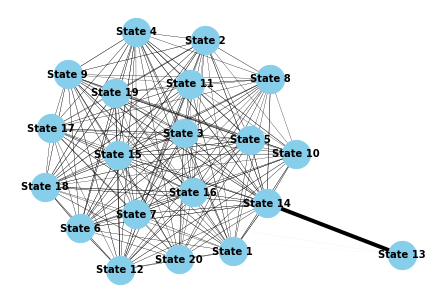

In [35]:
transition_matrix = model.transmat_.copy()
np.fill_diagonal(transition_matrix, 0)

plot_transition_graph(transition_matrix, path)

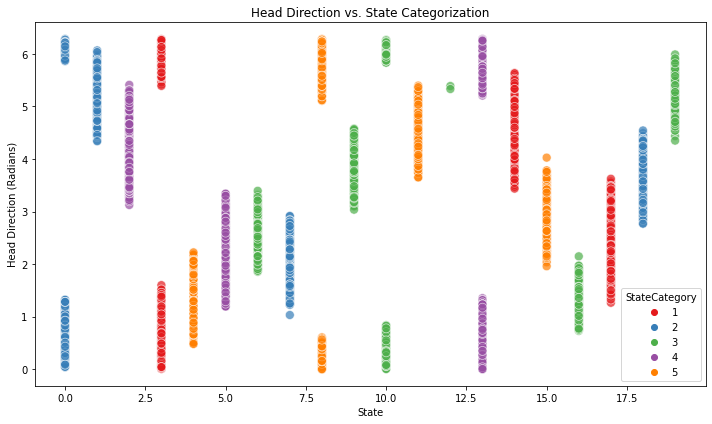

In [36]:
scatterplot_with_color(y_head, states_head, state_labels=y_state, path=path)

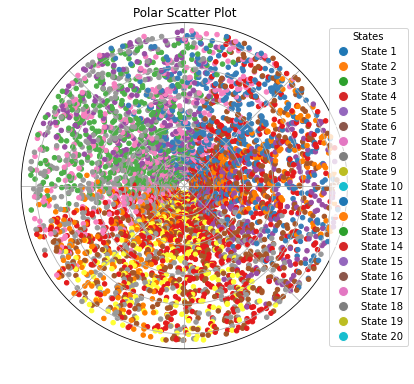

In [37]:
plot_polar_scatter(y_head, states_head, path)

# Test

In [7]:
n_state_list = [2,3,4]
m_dimensions = 5

In [8]:
lambda_list = []
for N in n_state_list:
    lambda_list.append(torch.rand(N, m_dimensions)*10)
lambdas = torch.stack(lambda_list, dim = 0)

RuntimeError: stack expects each tensor to be equal size, but got [2, 5] at entry 0 and [3, 5] at entry 1

In [29]:
import torch
import itertools

# Example: Create a list of sets (each represented as a torch tensor)
sets = [torch.tensor([1, 2, 3]), torch.tensor([1, 5]), torch.tensor([1, 7, 8])]

# Initialize an empty list to store the combinations
combinations = []

# Generate all combinations of sets
combinations = []
for combo in itertools.product(*sets):
    combinations.append(torch.stack(list(combo)).sum())

# Convert the list of combinations into a single tensor
combined_set = torch.stack(combinations)

# The 'combined_set' tensor now contains all possible combinations of elements added together
print(combined_set)

tensor([ 3,  9, 10,  7, 13, 14,  4, 10, 11,  8, 14, 15,  5, 11, 12,  9, 15, 16])


RuntimeError: stack expects each tensor to be equal size, but got [3] at entry 0 and [2] at entry 1

In [48]:
combined_tensor = combined_set.reshape((3,2,3)).sum(dim = -1)

In [47]:
tuple(range(1,3))

(1, 2)

In [49]:
combined_tensor.shape

torch.Size([3, 2])

In [10]:
combinations

[tensor([11., 11., 11.]),
 tensor([12., 12., 12.]),
 tensor([13., 13., 13.]),
 tensor([12., 12., 12.]),
 tensor([13., 13., 13.]),
 tensor([14., 14., 14.]),
 tensor([12., 12., 12.]),
 tensor([13., 13., 13.]),
 tensor([14., 14., 14.]),
 tensor([13., 13., 13.]),
 tensor([14., 14., 14.]),
 tensor([15., 15., 15.]),
 tensor([13., 13., 13.]),
 tensor([14., 14., 14.]),
 tensor([15., 15., 15.]),
 tensor([14., 14., 14.]),
 tensor([15., 15., 15.]),
 tensor([16., 16., 16.])]